In [2]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B2

In [11]:
# Cell 2: Define constants
BATCH_SIZE = 64
IMG_HEIGHT = 300 
IMG_WIDTH = 300
DATA_DIR = "/home/anon/MajorProject/Data/final_asl_mix"

In [12]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 80500 files belonging to 18 classes.
Using 64400 files for training.
Found 80500 files belonging to 18 classes.
Using 16100 files for validation.
['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']


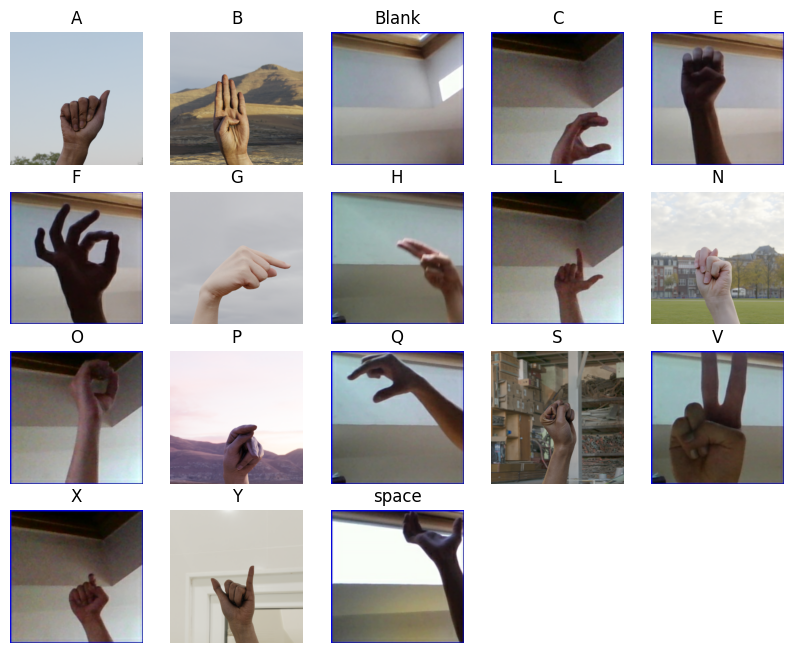

In [6]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [7]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [13]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [14]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [9]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


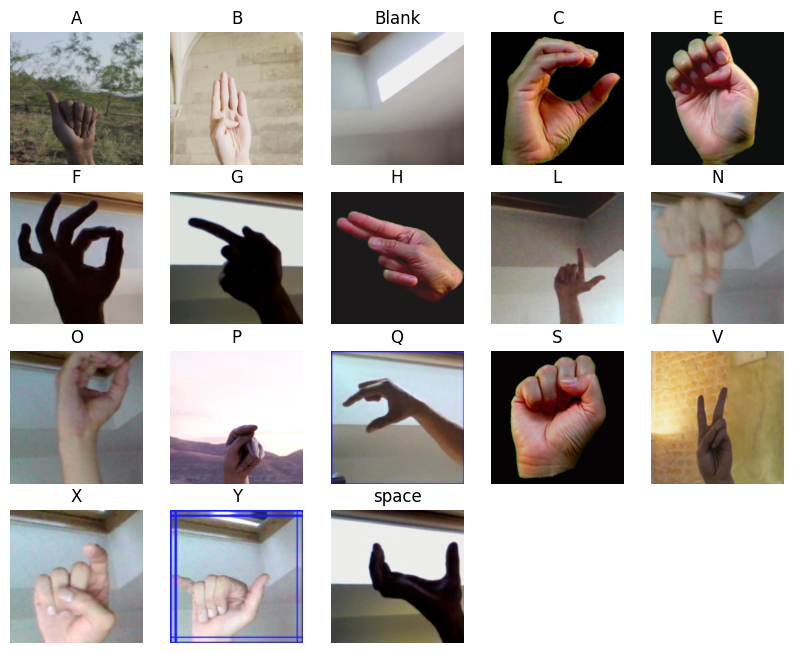

In [15]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [17]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2B2(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNetV2B2")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [18]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (64, 300, 300, 3), labels shape: (64,)
Validation images shape: (64, 300, 300, 3), labels shape: (64,)


In [19]:
print(model.summary())

Model: "EfficientNetV2B2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_1 (Rescaling)     (None, 300, 300, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 300, 300, 3)          0         ['rescaling_1[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 32)         864       ['normalization

In [20]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/final/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [21]:
#Cell 8 train the model
epochs = 60
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/60


2024-02-22 13:35:31.065134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


   1/1007 [..............................] - ETA: 2:18:42 - loss: 4.5938 - accuracy: 0.0781 - sparse_categorical_accuracy: 0.0781 - sparse_top_k_categorical_accuracy: 0.2969

2024-02-22 13:35:33.193592: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f705090a830 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-22 13:35:33.193620: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-02-22 13:35:33.202659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708588233.252527    1703 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1007/1007 [==============================] - ETA: 0s - loss: 2.6159 - accuracy: 0.3678 - sparse_categorical_accuracy: 0.3678 - sparse_top_k_categorical_accuracy: 0.7079

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1007/1007 [==============================] - 130s 121ms/step - loss: 2.6159 - accuracy: 0.3678 - sparse_categorical_accuracy: 0.3678 - sparse_top_k_categorical_accuracy: 0.7079 - val_loss: 1.1386 - val_accuracy: 0.7984 - val_sparse_categorical_accuracy: 0.7984 - val_sparse_top_k_categorical_accuracy: 0.9592 - lr: 9.8946e-05
Epoch 2/60
1007/1007 [==============================] - 120s 119ms/step - loss: 1.5033 - accuracy: 0.6372 - sparse_categorical_accuracy: 0.6372 - sparse_top_k_categorical_accuracy: 0.9099 - val_loss: 0.8257 - val_accuracy: 0.8646 - val_sparse_categorical_accuracy: 0.8646 - val_sparse_top_k_categorical_accuracy: 0.9799 - lr: 9.7901e-05
Epoch 3/60
1007/1007 [==============================] - 121s 120ms/step - loss: 1.1746 - accuracy: 0.7239 - sparse_categorical_accuracy: 0.7239 - sparse_top_k_categorical_accuracy: 0.9454 - val_loss: 0.6870 - val_accuracy: 0.8952 - val_sparse_categorical_accuracy: 0.8952 - val_sparse_top_k_categorical_accuracy: 0.9875 - lr: 9.6868e-05


In [22]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientnetV2B2/EfficientNetV2B2_FEB_22_batch_size_64_18_classes_A_B_Blank_C_E_F_G_H_L_N_O_P_Q_S_V_X_Y_space.h5')

In [23]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 [==============================] - 2s 318ms/step


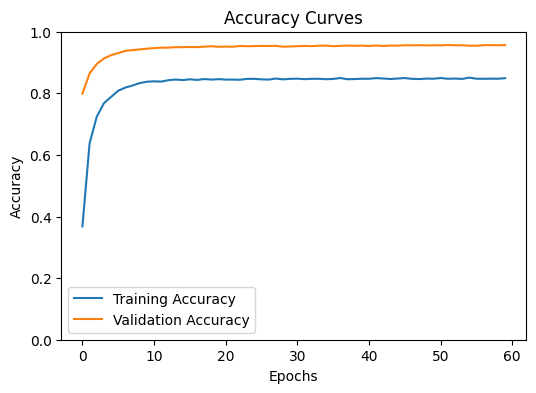

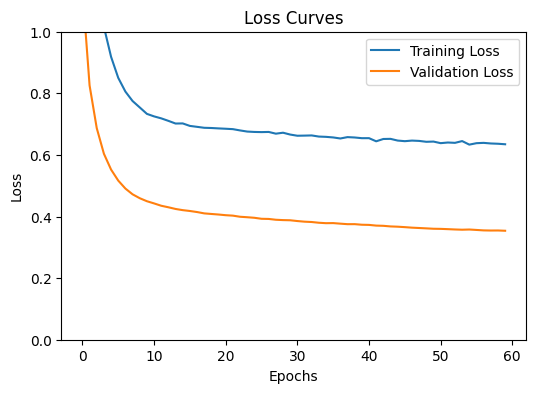

In [24]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Class: A
Precision: 0.9465968586387434
Recall: 0.9387331256490135
F1 Score: 0.9426485922836287
AUC-ROC: 0.9676819489644288

Class: B
Precision: 0.9728260869565217
Recall: 0.9835164835164835
F1 Score: 0.9781420765027322
AUC-ROC: 0.9909353319491568

Class: Blank
Precision: 0.9951865222623345
Recall: 0.9963855421686747
F1 Score: 0.9957856712823601
AUC-ROC: 0.9980617953148547

Class: C
Precision: 0.9769736842105263
Recall: 0.9801980198019802
F1 Score: 0.9785831960461285
AUC-ROC: 0.9894078111648963

Class: E
Precision: 0.9659090909090909
Recall: 0.9081196581196581
F1 Score: 0.9361233480176211
AUC-ROC: 0.9530706441481962

Class: F
Precision: 0.9728199320498301
Recall: 0.9565701559020044
F1 Score: 0.9646266142616507
AUC-ROC: 0.9774957081312416

Class: G
Precision: 0.9467120181405896
Recall: 0.9403153153153153
F1 Score: 0.943502824858757
AUC-ROC: 0.9686128246310995

Class: H
Precision: 0.9529025191675794
Recall: 0.9775280898876404
F1 Score: 0.9650582362728786
AUC-ROC: 0.9873505012225842

Class

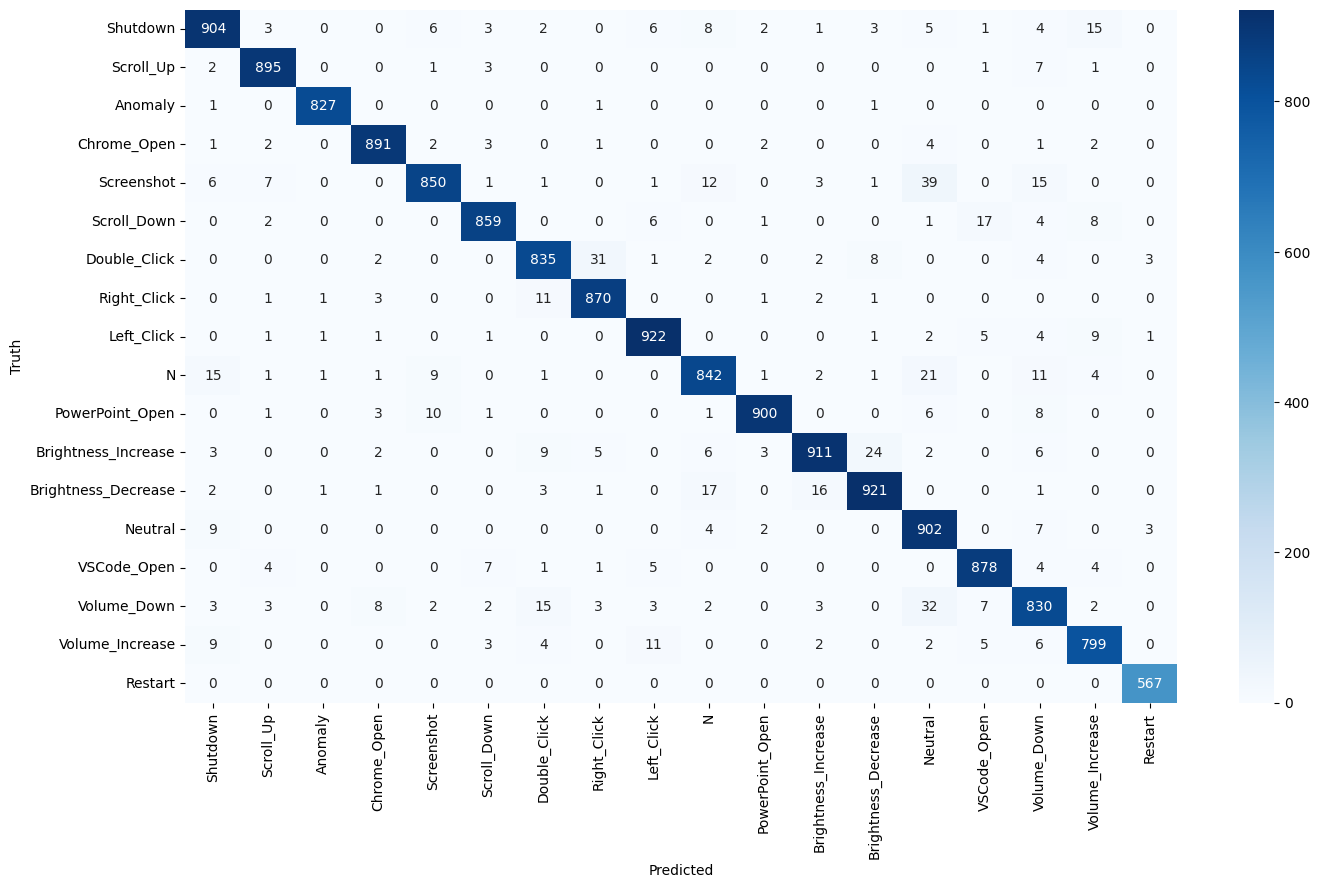

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
# Define the mapping between class names and labels
# ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'K', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space']


#feb 22
# 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space'
class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double_Click',
    'H': 'Right_Click',
    # 'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    # 'R': 'Right_Click',
    'S': 'Neutral',
    'V': 'VSCode_Open',
    # 'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    # '5': 'Neutral',
    'space':'Restart',
    # 'K': 'K'
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [26]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block2a_expand_conv
15 block2a_expand_bn
16 block2a_expand_activation
17 block2a_project_conv
18 block2a_project_bn
19 block2b_expand_conv
20 block2b_expand_bn
21 block2b_expand_activation
22 block2b_project_conv
23 block2b_project_bn
24 block2b_drop
25 block2b_add
26 block2c_expand_conv
27 block2c_expand_bn
28 block2c_expand_activation
29 block2c_project_conv
30 block2c_project_bn
31 block2c_drop
32 block2c_add
33 block3a_expand_conv
34 block3a_expand_bn
35 block3a_expand_activation
36 block3a_project_conv
37 block3a_project_bn
38 block3b_expand_conv
39 block3b_expand_bn
40 block3b_expand_activation
41 block3b_project_conv
42 block3b_project_bn
43 block3b_drop
44 block3b_add
45 block3c_expand_conv
46 block3c_expand_bn
47 bloc

In [27]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:350]:
   layer.trainable = False
for layer in model.layers[350:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 20
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/20


2024-02-22 15:43:18.536914: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2024-02-22 15:43:18.638763: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1006/1007 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.8490 - sparse_categorical_accuracy: 0.8490 - sparse_top_k_categorical_accuracy: 0.9839

2024-02-22 15:45:06.110906: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 129s 122ms/step - loss: 0.6336 - accuracy: 0.8490 - sparse_categorical_accuracy: 0.8490 - sparse_top_k_categorical_accuracy: 0.9839 - val_loss: 0.3527 - val_accuracy: 0.9565 - val_sparse_categorical_accuracy: 0.9565 - val_sparse_top_k_categorical_accuracy: 0.9976 - lr: 1.0000e-06
Epoch 2/20
   2/1007 [..............................] - ETA: 1:46 - loss: 0.5712 - accuracy: 0.8750 - sparse_categorical_accuracy: 0.8750 - sparse_top_k_categorical_accuracy: 0.9766

2024-02-22 15:45:21.952572: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1006/1007 [============================>.] - ETA: 0s - loss: 0.6323 - accuracy: 0.8502 - sparse_categorical_accuracy: 0.8502 - sparse_top_k_categorical_accuracy: 0.9840

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1007/1007 [==============================] - 120s 120ms/step - loss: 0.6323 - accuracy: 0.8502 - sparse_categorical_accuracy: 0.8502 - sparse_top_k_categorical_accuracy: 0.9840 - val_loss: 0.3523 - val_accuracy: 0.9571 - val_sparse_categorical_accuracy: 0.9571 - val_sparse_top_k_categorical_accuracy: 0.9976 - lr: 1.0000e-06
Epoch 3/20
   2/1007 [..............................] - ETA: 1:46 - loss: 0.5809 - accuracy: 0.8516 - sparse_categorical_accuracy: 0.8516 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-22 15:47:22.482076: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 121s 120ms/step - loss: 0.6302 - accuracy: 0.8514 - sparse_categorical_accuracy: 0.8514 - sparse_top_k_categorical_accuracy: 0.9842 - val_loss: 0.3522 - val_accuracy: 0.9568 - val_sparse_categorical_accuracy: 0.9568 - val_sparse_top_k_categorical_accuracy: 0.9976 - lr: 1.0000e-06
Epoch 4/20
   2/1007 [..............................] - ETA: 1:45 - loss: 0.4439 - accuracy: 0.9062 - sparse_categorical_accuracy: 0.9062 - sparse_top_k_categorical_accuracy: 0.9922

2024-02-22 15:49:23.457871: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 122s 121ms/step - loss: 0.6335 - accuracy: 0.8496 - sparse_categorical_accuracy: 0.8496 - sparse_top_k_categorical_accuracy: 0.9840 - val_loss: 0.3519 - val_accuracy: 0.9573 - val_sparse_categorical_accuracy: 0.9573 - val_sparse_top_k_categorical_accuracy: 0.9976 - lr: 1.0000e-06
Epoch 5/20
   2/1007 [..............................] - ETA: 1:46 - loss: 0.6135 - accuracy: 0.8828 - sparse_categorical_accuracy: 0.8828 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-22 15:51:25.679555: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 123s 122ms/step - loss: 0.6311 - accuracy: 0.8484 - sparse_categorical_accuracy: 0.8484 - sparse_top_k_categorical_accuracy: 0.9842 - val_loss: 0.3515 - val_accuracy: 0.9572 - val_sparse_categorical_accuracy: 0.9572 - val_sparse_top_k_categorical_accuracy: 0.9976 - lr: 1.0000e-06
Epoch 6/20
   2/1007 [..............................] - ETA: 1:45 - loss: 0.5042 - accuracy: 0.9062 - sparse_categorical_accuracy: 0.9062 - sparse_top_k_categorical_accuracy: 1.0000

2024-02-22 15:53:28.682224: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 124s 123ms/step - loss: 0.6290 - accuracy: 0.8513 - sparse_categorical_accuracy: 0.8513 - sparse_top_k_categorical_accuracy: 0.9847 - val_loss: 0.3519 - val_accuracy: 0.9572 - val_sparse_categorical_accuracy: 0.9572 - val_sparse_top_k_categorical_accuracy: 0.9977 - lr: 1.0000e-06
Epoch 7/20
   2/1007 [..............................] - ETA: 1:50 - loss: 0.6919 - accuracy: 0.8203 - sparse_categorical_accuracy: 0.8203 - sparse_top_k_categorical_accuracy: 0.9766

2024-02-22 15:55:32.889431: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 123s 122ms/step - loss: 0.6310 - accuracy: 0.8498 - sparse_categorical_accuracy: 0.8498 - sparse_top_k_categorical_accuracy: 0.9846 - val_loss: 0.3520 - val_accuracy: 0.9570 - val_sparse_categorical_accuracy: 0.9570 - val_sparse_top_k_categorical_accuracy: 0.9977 - lr: 1.0000e-06
Epoch 8/20
   2/1007 [..............................] - ETA: 1:43 - loss: 0.5024 - accuracy: 0.9219 - sparse_categorical_accuracy: 0.9219 - sparse_top_k_categorical_accuracy: 0.9844

2024-02-22 15:57:35.591567: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 69120256 bytes after encountering the first element of size 69120256 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1007/1007 [==============================] - 125s 124ms/step - loss: 0.6287 - accuracy: 0.8523 - sparse_categorical_accuracy: 0.8523 - sparse_top_k_categorical_accuracy: 0.9841 - val_loss: 0.3516 - val_accuracy: 0.9570 - val_sparse_categorical_accuracy: 0.9570 - val_sparse_top_k_categorical_accuracy: 0.9977 - lr: 1.0000e-06


In [28]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


2/2 [==============================] - 2s 54ms/step


Class: A
Precision: 0.9494736842105264
Recall: 0.936656282450675
F1 Score: 0.9430214323052797
AUC-ROC: 0.9667426222982053

Class: B
Precision: 0.9749182115594329
Recall: 0.9824175824175824
F1 Score: 0.9786535303776683
AUC-ROC: 0.9904517141844331

Class: Blank
Precision: 0.9951865222623345
Recall: 0.9963855421686747
F1 Score: 0.9957856712823601
AUC-ROC: 0.9980617953148547

Class: C
Precision: 0.9780461031833151
Recall: 0.9801980198019802
F1 Score: 0.9791208791208791
AUC-ROC: 0.9894407253904245

Class: E
Precision: 0.9606299212598425
Recall: 0.9123931623931624
F1 Score: 0.9358904109589041
AUC-ROC: 0.9550425321330095

Class: F
Precision: 0.9696629213483146
Recall: 0.9610244988864143
F1 Score: 0.9653243847874721
AUC-ROC: 0.9796242083959765

Class: G
Precision: 0.943502824858757
Recall: 0.9403153153153153
F1 Score: 0.9419063733784546
AUC-ROC: 0.9685142182677023

Class: H
Precision: 0.954945054945055
Recall: 0.9764044943820225
F1 Score: 0.9655555555555555
AUC-ROC: 0.9868544496893675

Class: 

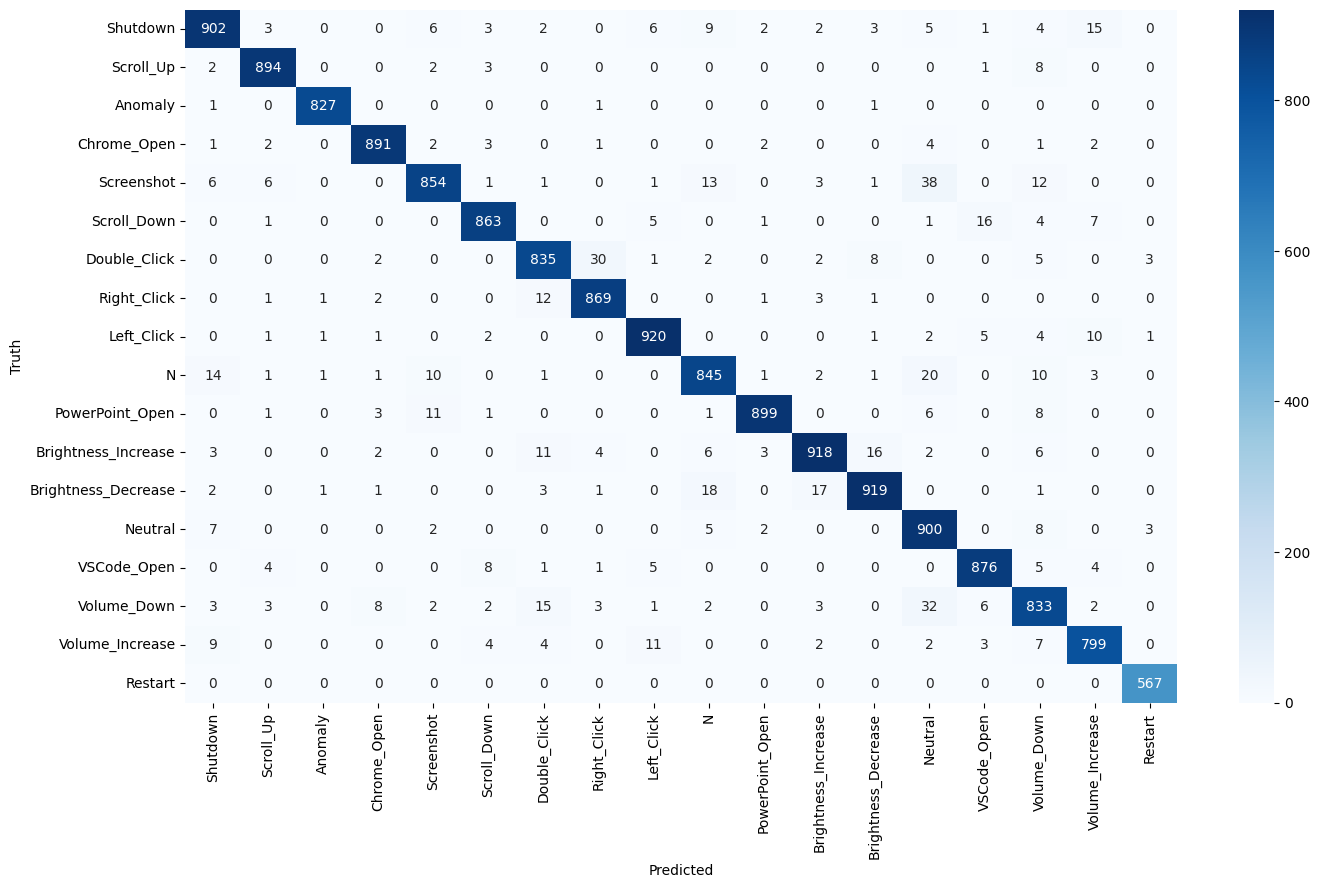

In [29]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import confusion_matrix, roc_auc_score
# from sklearn.preprocessing import LabelBinarizer
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Accuracy
# accuracy = accuracy_score(y_true, y_pred)

# # Precision, Recall, F1 Score
# average = 'macro'  # or 'micro', 'weighted', depending on the problem
# precision = precision_score(y_true, y_pred, average=average)
# recall = recall_score(y_true, y_pred, average=average)
# f1 = f1_score(y_true, y_pred, average=average)

# # AUC-ROC for multiclass
# lb = LabelBinarizer()
# lb.fit(y_true)
# y_true_lb = lb.transform(y_true)
# y_pred_lb = lb.transform(y_pred)
# auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# # Confusion Matrix
# cm = confusion_matrix(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy}")
# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1 Score: {f1}")
# print(f"AUC-ROC: {auc_roc}")

# #for dataset_alpha
# # class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# # class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
# # class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
# #for final_asl_mix
# # class_names = ['A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'U', 'V', 'W', 'X', 'Y']

# #feb 20 final
# class_names = ['5', 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'I', 'L', 'N', 'O', 'P', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'space']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score for each class
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# AUC-ROC for each class
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=None, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
#feb 22
# 'A', 'B', 'Blank', 'C', 'E', 'F', 'G', 'H', 'L', 'N', 'O', 'P', 'Q', 'S', 'V', 'X', 'Y', 'space'
class_label_mapping = {
    'A': 'Shutdown',
    'B': 'Scroll_Up',
    'Blank': 'Anomaly',
    'C': 'Chrome_Open',
    'E': 'Screenshot',
    'F': 'Scroll_Down',
    'G': 'Double_Click',
    'H': 'Right_Click',
    # 'I': 'I',
    'L': 'Left_Click',
    'N': 'N',
    'O': 'PowerPoint_Open',
    'P': 'Brightness_Increase',
    'Q': 'Brightness_Decrease',
    # 'R': 'Right_Click',
    'S': 'Neutral',
    'V': 'VSCode_Open',
    # 'W': 'W',
    'X': 'Volume_Down',
    'Y': 'Volume_Increase',
    # '5': 'Neutral',
    'space':'Restart',
    # 'K
}
# Create a dictionary that maps indices to labels
class_labels = {i: class_label_mapping[name] for i, name in enumerate(class_names)}

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")
    print(f"AUC-ROC: {auc_roc[i]}")
    print()

# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(16,9))
# sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels.values(), yticklabels=class_labels.values(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9779498528715005


In [33]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2B2/EfficientNetV2B2_FEB_22_batch_size_64_18_classes_A_B_Blank_C_E_F_G_H_L_N_O_P_Q_S_V_X_Y_space_finetuned.h5')

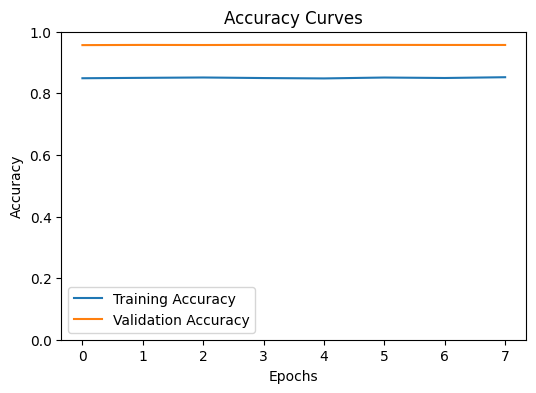

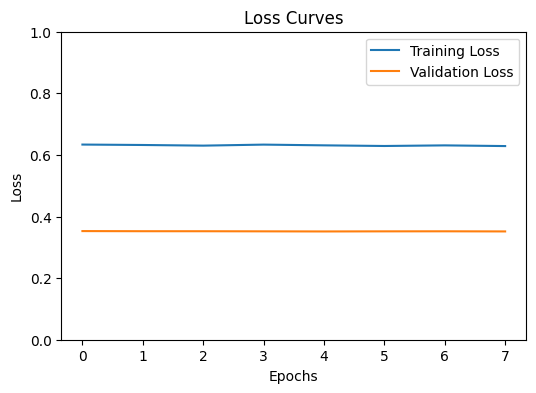

In [32]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
